## Imports

In [1]:
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import linear_model    # LogisticRegression
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__)

Pandas   1.2.0
Sklearn  0.23.2
LightGBM 3.1.1


## Get the dataset
- **CLOUD = True**: Download dataset from Kaggle. Necesary for cloud enviroments like COLAB. **Specify your [kaggle credentials](https://www.kaggle.com/docs/api)**.
- **CLOUD = False**: Get the dataset from your local machine. **Specify the data path**.

In [2]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "your_kaggle_username"
    os.environ['KAGGLE_KEY']      = "your_kaggle_api_key"  # See https://www.kaggle.com/docs/api
    !pip install --upgrade kaggle
    !kaggle competitions download -c titanic
    DATA_PATH = "./"

else:
    DATA_PATH = "../../datasets/titanic/"

## Load data

In [3]:
df      = pd.read_csv(DATA_PATH + "train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)
df.head(5)

Train DataFrame: (891, 11)
Test DataFrame:  (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Check missings

In [5]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
df_test.isnull().sum() # Fare has Missings only in TEST !!!

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

# Preprocessing
For X data:
- We drop Survived because is the target variable
- We drop Name for simplicity. (We could extract Mr, Mrs, ...)
- We drop Ticket because it has no information -> see df.Ticket.nunique()
- We drop Cabin because it has a lot of missings (77% are missings)

Then, we identify **numerical** variables and **categorical** variables,

In [7]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

In [8]:
cat_vars  = x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = x.select_dtypes(exclude=[object]).columns.values.tolist()

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical features:
 ['Sex', 'Embarked']


In [9]:
#x.isnull().sum()

In [10]:
#x_test.isnull().sum()

In [11]:
num_preprocessing = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean', add_indicator=False)), # mean, median
    ('scaler', preprocessing.StandardScaler())
])

cat_preporcessing = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

prepro = compose.ColumnTransformer(transformers=[
    ('num', num_preprocessing, num_vars),
    ('cat', cat_preporcessing, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked'])])

In [12]:
x_prepro      = prepro.fit_transform(x)  # ONLY FIT THE PREPROCESSOR ON TRAIN TO AVOID DATA LEAKS !!!
x_test_prepro = prepro.transform(x_test)

x_prepro.shape, x_test_prepro.shape

((891, 11), (418, 11))

# Check our preprocesed data

In [13]:
cat_vars_oh = prepro.named_transformers_["cat"]["onehot"].get_feature_names(cat_vars).tolist()
cat_vars_oh

['Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Embarked_missing']

In [14]:
pd.DataFrame(data = x_prepro, columns=num_vars+cat_vars_oh).head() # X DATA (WILL BE TRAIN+VALID DATA)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0,0.0
2,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.566107,0.407926,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0,0.0
4,0.827377,0.407926,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0


In [15]:
pd.DataFrame(data = x_test_prepro, columns=num_vars+cat_vars_oh).head() # X_TEST DATA (NEW DATA)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,0.827377,0.369449,-0.474545,-0.473674,-0.490783,0.0,1.0,0.0,1.0,0.0,0.0
1,0.827377,1.331378,0.432793,-0.473674,-0.507479,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.369365,2.485693,-0.474545,-0.473674,-0.453367,0.0,1.0,0.0,1.0,0.0,0.0
3,0.827377,-0.207709,-0.474545,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0,0.0
4,0.827377,-0.592481,0.432793,0.767630,-0.401017,1.0,0.0,0.0,0.0,1.0,0.0


# Validation Strategy

Simple split:
- 80% for train
- 20% for validation

In [16]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_prepro, y,
    test_size=0.2,
    stratify = y,   # ALWAYS RECOMMENDED FOR BETTER VALIDATION
    random_state=4  # Recommended for reproducibility
)

# Train Model

In [17]:
model = linear_model.LogisticRegression(max_iter=2000, random_state=1)
model.fit(x_train, y_train)

LogisticRegression(max_iter=2000, random_state=1)

## Full Pipeline: Prepro + Model

In [18]:
full_model = pipeline.Pipeline([('preprocessor', prepro), ('model', model)])
full_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('model', LogisticRegression(max_iter=2000, random_state=1))])

# Validate

See performance metrics like:
- Accuracy
- Balanced Accuracy
- Confusion matrix

In [19]:
# Get Predictions
y_pred       = model.predict(x_val)
y_pred_proba = model.predict_proba(x_val)[:, 1]

y_pred[:3], y_pred_proba[:3]

(array([1, 0, 1]), array([0.95059557, 0.09681743, 0.82229495]))

Accuracy:           81.56424581005587
Balanced accuracy:  80.13833992094861
Log loss:           0.4419711392584683
AUC:                85.41501976284584


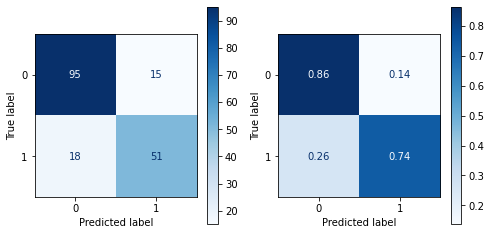

In [20]:
# See metrics
print("Accuracy:          ", metrics.accuracy_score(y_val, y_pred)*100)
print("Balanced accuracy: ", metrics.balanced_accuracy_score(y_val, y_pred)*100)
print("Log loss:          ", metrics.log_loss(y_val, y_pred_proba))
print("AUC:               ", metrics.roc_auc_score(y_val, y_pred_proba)*100) # Area Under ROC Curve


_, axes = plt.subplots(1, 2, figsize=(8, 4))
metrics.plot_confusion_matrix(model, x_val, y_val,
                      cmap=plt.cm.Blues, normalize=None,
                      ax=axes[0]);

metrics.plot_confusion_matrix(model, x_val, y_val,
                      cmap=plt.cm.Blues, normalize="true",
                      ax=axes[1]);

## See cofficients (Only for linear models)

In [21]:
coefs = pd.DataFrame(data=model.coef_[0].tolist(), index=num_vars+cat_vars_oh, columns=["Coefs"]).sort_values(by="Coefs")
coefs

,Coefs
Sex_male,-1.331785
Pclass,-0.883365
Age,-0.402286
SibSp,-0.254233
Embarked_S,-0.251845
Embarked_Q,-0.097245
Parch,-0.060917
Fare,0.045701
Embarked_C,0.169444
Embarked_missing,0.179531


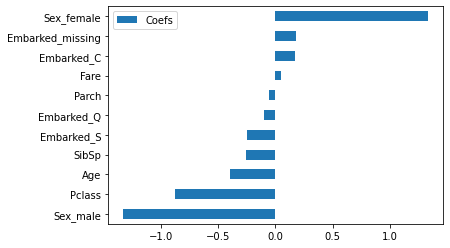

In [22]:
coefs.plot.barh();